In [1]:
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


In [2]:
import surp
from surp import gce_math as gcem
import arya

from surp import subgiants

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
data_dir = surp._globals.DATA_DIR

In [4]:
def scotts_bin_width(x):
    f = np.isfinite(x)
    N = len(x)
    return 3.49 * np.std(x[f]) / np.cbrt(N)

def scotts_bins(x):
    f = np.isfinite(x)
    return np.arange(np.min(x[f]), np.nanmax(x[f]), scotts_bin_width(x))

In [5]:
def hist(x, **kwargs):
    bins = scotts_bins(x)
    plt.hist(x, bins=bins, **kwargs)

In [6]:
def hist2d(x, y, bins=None, **kwargs):
    if bins is None:
        xbins = scotts_bins(x)
        ybins = scotts_bins(y)
        
    plt.hist2d(x, y, norm="log", bins=(xbins, ybins), **kwargs)

In [7]:
def keil_plot(teff, logg, bins=None, **kwargs):
    if bins is None:
        bins = 200
        xbins = np.linspace(np.nanmin(teff), np.nanmax(teff), bins)
        ybins = np.linspace(np.nanmin(logg), np.nanmax(logg), bins)
        
    plt.hist2d(teff, logg, norm="log", bins=(xbins, ybins), **kwargs)
    plt.colorbar(label="density")
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xlabel(r"$T_{\rm eff}$ / K")
    plt.ylabel(r"$\log g$")

In [8]:
def to_nice_name(apogee_name):
    name = apogee_name.replace("_", "/").title()
    name = f"[{name}]"
    return name

In [9]:
def plot_ab(df, x, y, **kwargs):
    hist2d(df[x], df[y], **kwargs)
    arya.medianplot(df, x, y, numbins=25, color="k")
    plt.xlabel(to_nice_name(x))
    plt.ylabel(to_nice_name(y))

# GALAH DR3

see https://www.galah-survey.org/dr3/using_the_data/.

In [ ]:
galah_all = Table.read(f"{data_dir}/GALAH_DR3_main_allstar_v2.fits", format="fits", memmap=True)

In [ ]:
# recommended cuts in documentation
mask = galah_all["flag_sp"] == 0
mask &= galah_all["flag_fe_h"] == 0
mask &= galah_all["snr_c3_iraf"] > 30
print(np.sum(mask))

mask &= ~np.isnan(galah_all["teff"])
mask &= ~np.isnan(galah_all["logg"])
print(np.sum(mask))

mask &= galah_all["e_logg"] < 0.5
mask &= galah_all["e_teff"] < 200
print(np.sum(mask))


df = galah_all[mask].to_pandas()

df["MG_H"] = df["Mg_fe"] + df["fe_h"]
df["C_MG"] = df["C_fe"] - df["Mg_fe"] 
df["C_O"] = df["C_fe"] - df["O_fe"] 

df["O_H"] = df["O_fe"] + df["fe_h"]
df["MG_O"] = df["O_fe"] - df["Mg_fe"]

df["FE_H"] = df["fe_h"]
df["MG_FE"] = df["Mg_fe"]


df["LOGG"] = df["logg"]
df["TEFF"] = df["teff"]

galah = df

In [ ]:
len(galah_all)

In [ ]:
len(galah)

In [ ]:
# make sure these things exist

abund_mask = galah["LOGG"] >= 3.5
abund_mask &= galah["TEFF"] >= 4500
abund_mask &= galah["TEFF"] <= 6500

abund_mask &= ~np.isnan(galah["C_MG"])
abund_mask &= ~np.isnan(galah["MG_FE"])
abund_mask &= ~np.isnan(galah["FE_H"])
abund_mask &= galah["flag_C_fe"] == 0
abund_mask &= (galah["flag_O_fe"] == 0) | (galah["flag_Mg_fe"] == 0)

galah_good = galah[abund_mask]
len(galah_good)

In [ ]:
print(len(galah_good))

In [ ]:
coords = [
    (3.5, 4800),
    (3.8, 4875),
    (4.0, 5300),
    (3.6, 5600),
    (3.5, 5250),
    (3.5, 4800)
]
y = [c[0] for c in coords]
x = [c[1] for c in coords]

In [ ]:
keil_plot(galah["TEFF"], galah["LOGG"])

## error histograms

In [ ]:
for key in ["e_logg", "e_teff", "e_fe_h", "e_O_fe", "e_Mg_fe", "e_C_fe",]:
    hist(galah[key], log=True);
    plt.xlabel(key)
    plt.show()

## abundance plots

In [ ]:

Nb = 30
bins = np.linspace(-1, 0.6, Nb)
hist = np.digitize(df["FE_H"], bins)

Nc = np.zeros(Nb)

h = np.zeros(Nb)
for b in range(Nb):
    filt = hist == b
    
    Nc[b] = np.sum(~np.isnan(df["C_fe"][filt]))
    h[b] = np.sum(filt)
    


In [ ]:
df["C_meas"] = ~np.isnan(df["C_fe"])

In [ ]:
fig, ax = plt.subplots() 
ax_twin = ax.twinx() 

plt.sca(ax)
#plt.plot(bins, Nc/h)
plt.ylabel('fractional completion')
plt.xlabel("[Fe/H]")
arya.medianplot(df, "FE_H", "C_meas", binsize=3000, stat="mean",  errorbar=None, label="completion")

plt.sca(ax_twin)
arya.medianplot(df, "FE_H", "C_MG", binsize=1000, errorbar=None, label="[C/Mg]", color=arya.style.COLORS[1])
plt.ylabel("[C/Mg]")

plt.sca(ax)
plt.legend(loc=2, bbox_to_anchor=(1, 0))
plt.sca(ax_twin)
plt.legend(loc=2, bbox_to_anchor=(1, 1))

In [ ]:
plot_ab(galah_good, "fe_h", "Mg_fe")

In [ ]:
plot_ab(galah_good, "fe_h", "MG_O")

In [ ]:
plot_ab(galah_good, "fe_h", "MG_O")

In [ ]:
plot_ab(galah_good, "MG_H", "C_MG")

In [ ]:
plot_ab(galah_good, "O_H", "C_O")

In [ ]:
plot_ab(galah_good, "MG_FE", "C_MG")

In [ ]:
plot_ab(galah_good, "O_fe", "C_O")

In [ ]:
galah_good.to_csv("galah_dwarfs.csv")

# GALAH DR4

see https://www.galah-survey.org/dr4/using_the_data/

In [10]:
galah_all = Table.read(f"{data_dir}/surveys/galah_dr4_allstar_240705.fits", format="fits", memmap=True)

In [11]:
galah_all.columns

<TableColumns names=('sobject_id','tmass_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec','flag_sp','flag_sp_fit','opt_loop','flag_red','snr_px_ccd1','snr_px_ccd2','snr_px_ccd3','snr_px_ccd4','chi2_sp','px_used_perc','model_name','closest_model','comp_time','fit_global_rv','rv_comp_1','e_rv_comp_1','rv_comp_2','e_rv_comp_2','rv_gaia_dr3','e_rv_gaia_dr3','v_bary_eff','teff','e_teff','logg','e_logg','fe_h','e_fe_h','flag_fe_h','vmic','e_vmic','vsini','e_vsini','nn_li_fe','nn_e_li_fe','nn_flag_li_fe','c_fe','e_c_fe','flag_c_fe','n_fe','e_n_fe','flag_n_fe','o_fe','e_o_fe','flag_o_fe','na_fe','e_na_fe','flag_na_fe','mg_fe','e_mg_fe','flag_mg_fe','al_fe','e_al_fe','flag_al_fe','si_fe','e_si_fe','flag_si_fe','k_fe','e_k_fe','flag_k_fe','ca_fe','e_ca_fe','flag_ca_fe','sc_fe','e_sc_fe','flag_sc_fe','ti_fe','e_ti_fe','flag_ti_fe','v_fe','e_v_fe','flag_v_fe','cr_fe','e_cr_fe','flag_cr_fe','mn_fe','e_mn_fe','flag_mn_fe','co_fe','e_co_fe','flag_co_fe','ni_fe','e_ni_fe','fla

In [12]:
# recommended cuts in documentation
mask = galah_all["flag_sp"] == 0
mask &= galah_all["flag_fe_h"] == 0
mask &= galah_all["snr_px_ccd3"] > 30
print(np.sum(mask))

mask &= ~np.isnan(galah_all["teff"])
mask &= ~np.isnan(galah_all["logg"])
print(np.sum(mask))

mask &= galah_all["e_logg"] < 0.5
mask &= galah_all["e_teff"] < 200
print(np.sum(mask))


df = galah_all[mask].to_pandas()

df["MG_H"] = df["mg_fe"] + df["fe_h"]
df["MG_H_ERR"] = df["e_mg_fe"] + df["e_fe_h"]
df["C_MG"] = df["c_fe"] - df["mg_fe"] 
df["C_MG_ERR"] = df["e_c_fe"] + df["e_mg_fe"]

df["C_O"] = df["c_fe"] - df["o_fe"] 

df["O_H"] = df["o_fe"] + df["fe_h"]
df["MG_O"] = df["o_fe"] - df["mg_fe"]

df["FE_H"] = df["fe_h"]
df["MG_FE"] = df["mg_fe"]
df["MG_FE_ERR"] = df["e_mg_fe"]



df["LOGG"] = df["logg"]
df["TEFF"] = df["teff"]

galah = df

549914
549914
530654


In [13]:
len(galah_all)

917588

In [14]:
len(galah)

530654

In [15]:
# make sure these things exist

abund_mask = galah["LOGG"] >= 3.5
abund_mask &= galah["TEFF"] >= 4500
abund_mask &= galah["TEFF"] <= 6500

abund_mask &= ~np.isnan(galah["C_MG"])
abund_mask &= ~np.isnan(galah["MG_FE"])
abund_mask &= ~np.isnan(galah["FE_H"])
abund_mask &= galah["flag_c_fe"] == 0
abund_mask &= (galah["flag_o_fe"] == 0) | (galah["flag_mg_fe"] == 0)

galah_good = galah[abund_mask]
len(galah_good)

28197

In [16]:
print(len(galah_good))

28197


In [17]:
coords = [
    (3.5, 4800),
    (3.8, 4875),
    (4.0, 5300),
    (3.6, 5600),
    (3.5, 5250),
    (3.5, 4800)
]
y = [c[0] for c in coords]
x = [c[1] for c in coords]

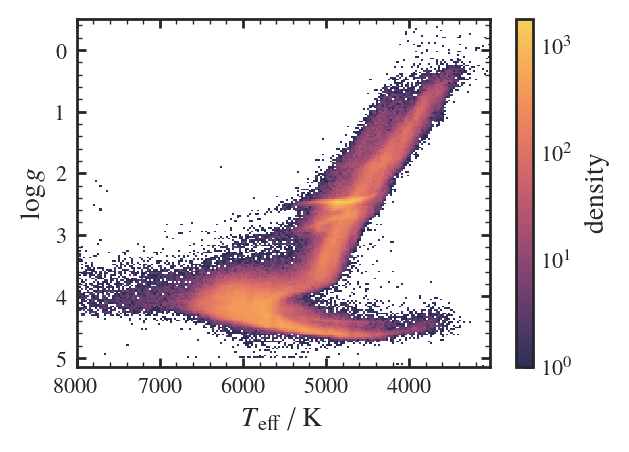

In [18]:
keil_plot(galah["TEFF"], galah["LOGG"])

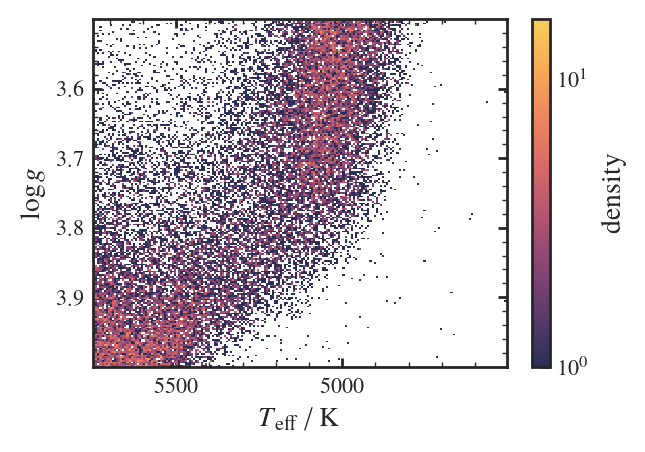

In [19]:
keil_plot(galah_good["TEFF"], galah_good["LOGG"])

## error histograms

In [ ]:
for key in ["e_logg", "e_teff", "e_fe_h", "e_o_fe", "e_mg_fe", "e_c_fe",]:
    hist(galah[key], log=True);
    plt.xlabel(key)
    plt.show()

## abundance plots

In [20]:

Nb = 30
bins = np.linspace(-1, 0.6, Nb)
hist = np.digitize(df["FE_H"], bins)

Nc = np.zeros(Nb)

h = np.zeros(Nb)
for b in range(Nb):
    filt = hist == b
    
    Nc[b] = np.sum(~np.isnan(df["c_fe"][filt]))
    h[b] = np.sum(filt)
    


In [21]:
df["C_meas"] = ~np.isnan(df["c_fe"])

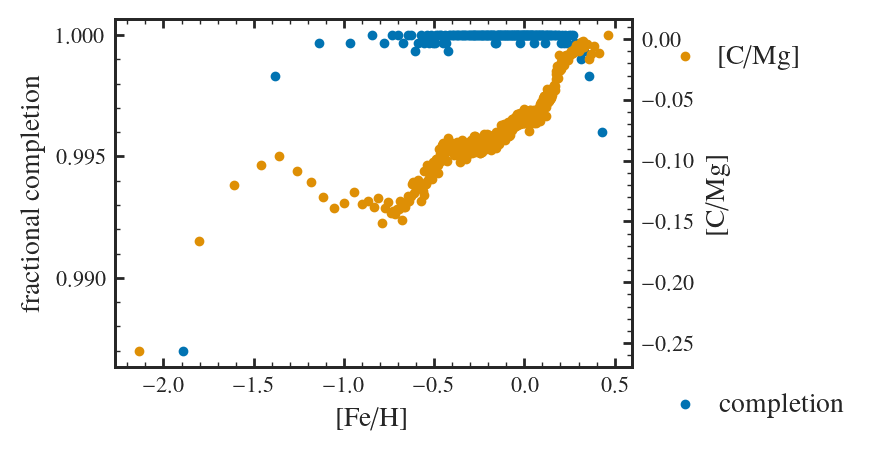

In [22]:
fig, ax = plt.subplots() 
ax_twin = ax.twinx() 

plt.sca(ax)
#plt.plot(bins, Nc/h)
plt.ylabel('fractional completion')
plt.xlabel("[Fe/H]")
arya.medianplot(df, "FE_H", "C_meas", binsize=3000, stat="mean",  errorbar=None, label="completion")

plt.sca(ax_twin)
arya.medianplot(df, "FE_H", "C_MG", binsize=1000, errorbar=None, label="[C/Mg]", color=arya.style.COLORS[1])
plt.ylabel("[C/Mg]")

plt.sca(ax)
plt.legend(loc=2, bbox_to_anchor=(1, 0))
plt.sca(ax_twin)
plt.legend(loc=2, bbox_to_anchor=(1, 1))

In [23]:
galah_good["high_alpha"] = np.where(galah_good.FE_H > 0, galah_good.MG_FE > 0.08 - 0.1*galah_good.FE_H, galah_good.MG_FE > 0.08 - 0.35*galah_good.FE_H)


/tmp/ipykernel_1933705/1037049553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  galah_good["high_alpha"] = np.where(galah_good.FE_H > 0, galah_good.MG_FE > 0.08 - 0.1*galah_good.FE_H, galah_good.MG_FE > 0.08 - 0.35*galah_good.FE_H)


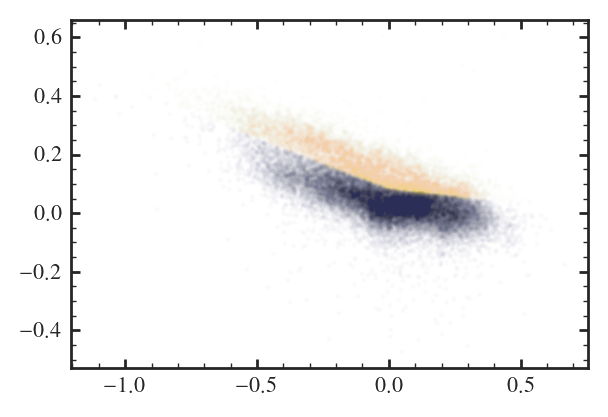

In [24]:
plt.scatter(galah_good.FE_H, galah_good.MG_FE, c=galah_good.high_alpha, s=1, alpha=0.01)

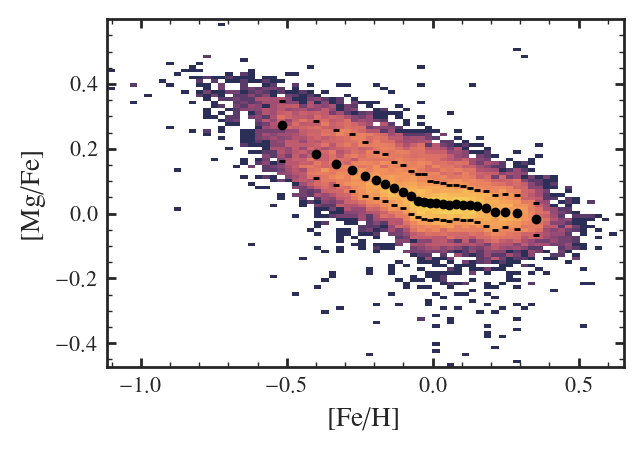

In [25]:
plot_ab(galah_good, "fe_h", "mg_fe")

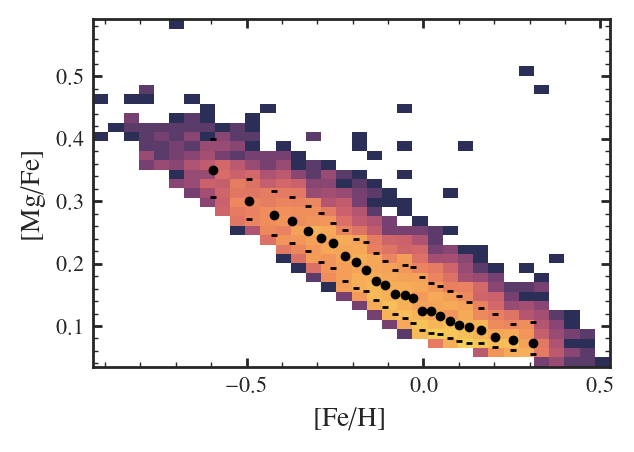

In [26]:
plot_ab(galah_good[galah_good.high_alpha], "fe_h", "mg_fe")

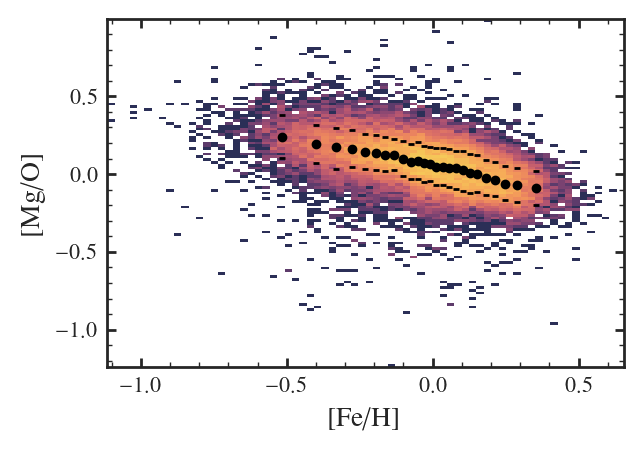

In [27]:
plot_ab(galah_good, "fe_h", "MG_O")

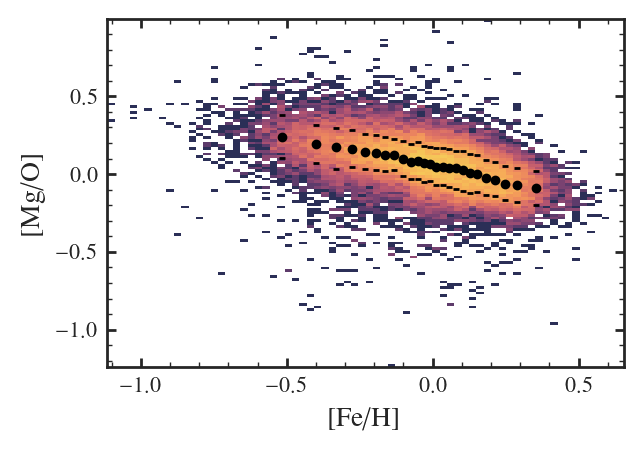

In [28]:
plot_ab(galah_good, "fe_h", "MG_O")

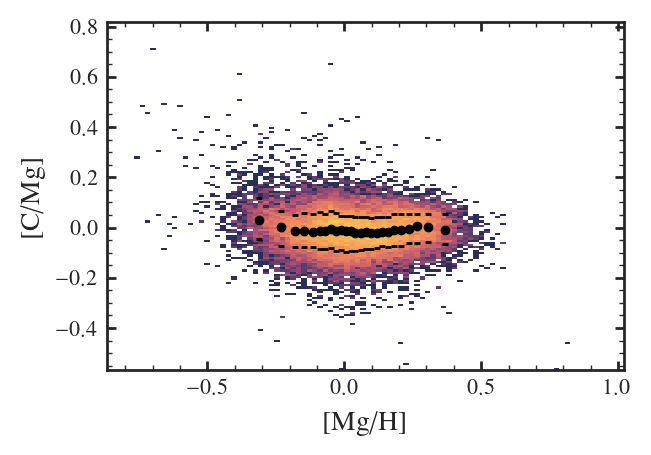

In [29]:
plot_ab(galah_good, "MG_H", "C_MG")

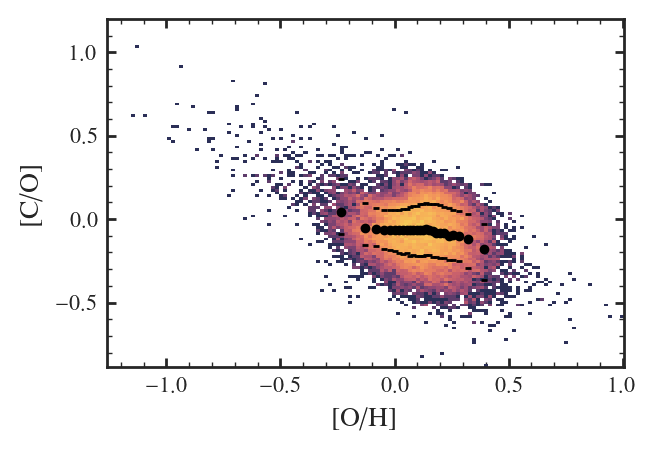

In [30]:
plot_ab(galah_good, "O_H", "C_O")

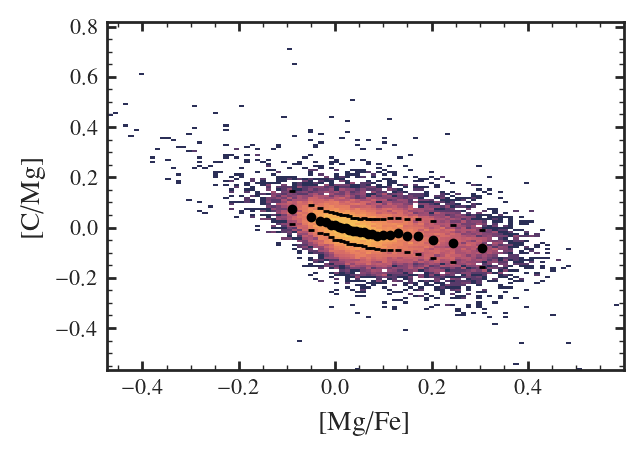

In [31]:
plot_ab(galah_good, "MG_FE", "C_MG")

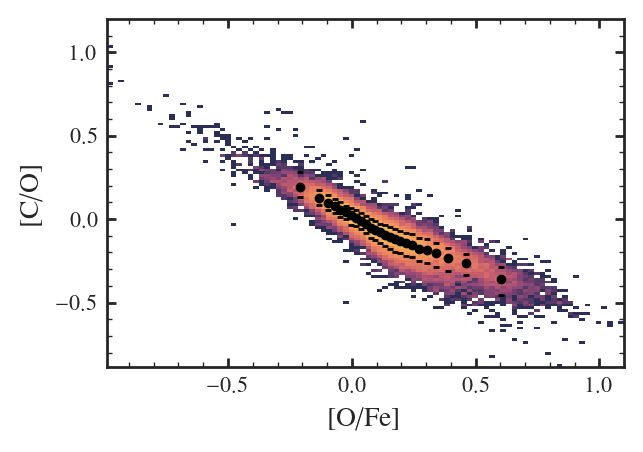

In [32]:
plot_ab(galah_good, "o_fe", "C_O")

In [33]:
galah_good.to_csv("galah_dwarfs.csv")

# GaiaESO


- DR 5.1
- WG 10 is the low resolution (GIRRAFFE), WG 11 is high res (UVES).
- Datamodel https://www.eso.org/qi/catalog/show/411.
- Description
https://www.eso.org/rm/api/v1/public/releaseDescriptions/191

In [35]:
gaiaeso_all = Table.read(f"{data_dir}/surveys/gaiaeso_dr5.1.fits", format="fits", memmap=True)

In [36]:
len(gaiaeso_all) == 114_916

True

Quality cuts

In [37]:
gaiaeso_all.columns

<TableColumns names=('OBJECT','GES_FLD','GES_TYPE','REC_SETUP','RAVAIL_SETUP','SETUP','REC_WG','RA','DECLINATION','SNR','TEFF','E_TEFF','NN_TEFF','ENN_TEFF','NNE_TEFF','LOGG','E_LOGG','NN_LOGG','ENN_LOGG','NNE_LOGG','FEH','E_FEH','NN_FEH','ENN_FEH','NNE_FEH','XI','E_XI','NN_XI','ENN_XI','NNE_XI','VRAD','E_VRAD','ORIGIN_VRAD','VRAD_OFFSET','VRAD_FLAG','NF_VRAD_FLAG','VSINI','E_VSINI','LIM_VSINI','LI1','LIM_LI1','E_LI1','VEIL','E_VEIL','EW_LI','LIM_EW_LI','E_EW_LI','EWC_LI','LIM_EWC_LI','E_EWC_LI','HA10','E_HA10','EW_HA_CHR','E_EW_HA_CHR','FHA_CHR','E_FHA_CHR','FWZI','E_FWZI','EW_HB_CHR','E_EW_HB_CHR','FHB_CHR','E_FHB_CHR','GAMMA','E_GAMMA','PECULI','TECH','SFLAGS','MEM3D','HE1','E_HE1','NN_HE1','ENN_HE1','NL_HE1','ORIGIN_HE1','C1','E_C1','NN_C1','ENN_C1','NL_C1','ORIGIN_C1','C2','E_C2','NN_C2','ENN_C2','NL_C2','ORIGIN_C2','C3','E_C3','NN_C3','ENN_C3','NL_C3','ORIGIN_C3','C_C2','E_C_C2','NN_C_C2','ENN_C_C2','NL_C_C2','ORIGIN_C_C2','N2','E_N2','NN_N2','ENN_N2','NL_N2','ORIGIN_N2','N3','E_

In [38]:
sflags = pd.Series(gaiaeso_all["SFLAGS"]).str.decode("utf-8")

quality_mask = ~sflags.str.contains("SNR")
quality_mask &= ~sflags.str.contains("SRP")
quality_mask &= ~sflags.str.contains("BIN") # binary
quality_mask &= ~sflags.str.contains("SSA")
quality_mask &= ~sflags.str.contains("IPA")
quality_mask &= ~sflags.str.contains("PSC")
quality_mask &= ~sflags.str.contains("EML") # emission line

print(np.sum(quality_mask))
quality_mask &= gaiaeso_all["E_LOGG"] < 0.5
quality_mask &= gaiaeso_all["E_TEFF"] < 200
print(np.sum(quality_mask))


gaiaeso = gaiaeso_all[quality_mask.values].to_pandas()

65102
52559


while e.g. MgII, C II are in the dataframe, none of these are successfuly measured for these stars

In [39]:
gaiaeso["MG_H"] = gcem.eps_to_brak(gaiaeso.MG1, "Mg")
gaiaeso["MG_H_ERR"] = gaiaeso.E_MG1

gaiaeso["CI_H"] = gcem.eps_to_brak(gaiaeso.C1, "C")
gaiaeso["CI_H_ERR"] = gaiaeso.E_C1
gaiaeso["CC_H"] = gcem.eps_to_brak(gaiaeso.C_C2, "C")
gaiaeso["CC_H_ERR"] = gaiaeso.E_C_C2

gaiaeso["FE_H"] = gaiaeso["FEH"]
gaiaeso["FE_H_ERR"] = gaiaeso["E_FEH"]


gaiaeso["MG_FE"] = gaiaeso.MG_H - gaiaeso.FE_H
gaiaeso["MG_FE_ERR"] = gaiaeso.MG_H_ERR + gaiaeso.FE_H_ERR
gaiaeso["C_MG"] = gaiaeso.CC_H - gaiaeso.MG_H
gaiaeso["C_MG_ERR"] = gaiaeso.MG_H_ERR + gaiaeso.CC_H_ERR

gaiaeso["CI_MG"] = gaiaeso.CI_H - gaiaeso.MG_H
gaiaeso["CI_MG_ERR"] = gaiaeso.MG_H_ERR + gaiaeso.CI_H_ERR


In [40]:
print(len(gaiaeso_all))
print(len(gaiaeso))

114916
52559


In [41]:
setup = gaiaeso.SETUP.str.decode("utf-8")

In [42]:
setup.unique()

array(['HR21                                                                                 ',
       'HR10|HR21                                                                            ',
       'U580                                                                                 ',
       'HR15N                                                                                ',
       'HR15N:U580                                                                           ',
       'HR10|HR21:HR15N                                                                      ',
       'HR15N:HR9B                                                                           ',
       'HR9B                                                                                 ',
       'HR15N:U520                                                                           ',
       'U520:U580                                                                            ',
       'HR10|HR21:U520                  

In [43]:
logg = gaiaeso.LOGG
teff = gaiaeso.TEFF

mask = ~np.isnan(logg)
mask &= ~np.isnan(teff)

mask &= logg >= 3.5
# mask &= logg <= 0.004*teff - 15.7
# mask &= logg <= 0.000706*teff + 0.36
# mask &= logg <= -0.0015 * teff + 12.05
# mask &= logg >= 0.0012*teff - 2.8


mask &= gaiaeso.E_MG1 > 0
#mask &= gaiaeso.C_MG_ERR > 0

subgiant_mask = np.copy(mask)


gso_dwarf = gaiaeso[subgiant_mask]

In [44]:
uves_filt = setup.str.contains("U580") | setup.str.contains("U520")
print(np.sum(uves_filt))
uves_filt &= gso_dwarf.REC_WG == b"WG11" # cuts out a few weird stars...
print(np.sum(uves_filt))

giraffe_filt = gso_dwarf.REC_WG == b"WG10"

550
263


In [45]:
gso_uv = gso_dwarf[uves_filt]
gso_uv

/tmp/ipykernel_1933705/192853501.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gso_uv = gso_dwarf[uves_filt]


,OBJECT,GES_FLD,GES_TYPE,REC_SETUP,RAVAIL_SETUP,SETUP,REC_WG,RA,DECLINATION,SNR,...,CC_H,CC_H_ERR,FE_H,FE_H_ERR,MG_FE,MG_FE_ERR,C_MG,C_MG_ERR,CI_MG,CI_MG_ERR
867,b'08101201-4720464',b'gamma2_Vel ',b'GE_CL ',b'U580 ',b'U580:HR15N ...,b'HR15N:U580 ...,b'WG11',122.550042,-47.346222,146.039993,...,NaN,NaN,-0.51,0.05,0.174104,0.08,NaN,NaN,-0.050235,0.1000
873,b'08071363-4725156',b'gamma2_Vel ',b'GE_CL ',b'U580 ',b'U580:HR15N ...,b'HR15N:U580 ...,b'WG11',121.806792,-47.421000,134.580002,...,-0.166131,0.03,-0.06,0.17,-0.115896,0.20,0.009765,0.06,0.049765,0.0800
874,b'08074019-4730403',b'gamma2_Vel ',b'GE_CL ',b'U580 ',b'U580:HR15N ...,b'HR15N:U580 ...,b'WG11',121.917458,-47.511194,194.080002,...,-0.206131,0.03,-0.12,0.17,-0.085896,0.21,-0.000235,0.07,-0.130235,0.1100
875,b'08080431-4716272',b'gamma2_Vel ',b'GE_CL ',b'U580 ',b'U580:HR15N ...,b'HR15N:U580 ...,b'WG11',122.017958,-47.274222,89.620003,...,-0.046131,0.03,-0.07,0.17,-0.035896,0.23,0.059764,0.09,0.309764,0.0700
904,b'08112313-4737105',b'gamma2_Vel ',b'GE_CL ',b'U580 ',b'U580:HR15N ...,b'HR15N:U580 ...,b'WG11',122.846375,-47.619583,121.419998,...,NaN,NaN,0.11,0.05,-0.115896,0.08,NaN,NaN,-0.140235,0.0400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51098,b'07382476+2143589',b'NGC2420 ',b'GE_SD_OC ',b'U580 ',b'HR15N:U580:HR15N ...,b'HR15N:U580 ...,b'WG11',114.603167,21.733028,17.270000,...,NaN,NaN,0.04,0.06,-0.185896,0.07,NaN,NaN,0.006765,0.1671
51311,b'15544883-6631444',b'GES_MW_15_16',b'GE_MW ',b'U580 ',b'U580 ...,b'U580 ...,b'WG11',238.703458,-66.529000,67.910004,...,NaN,NaN,0.21,0.11,-0.145896,0.26,NaN,NaN,0.049766,0.1600
51509,b'12200588-3702147',b'GES_MW_12_13',b'GE_MW ',b'U580 ',b'U580 ...,b'U580 ...,b'WG11',185.024500,-37.037417,60.250000,...,NaN,NaN,-0.18,0.05,0.424104,0.08,NaN,NaN,0.069765,0.0400
51682,b'18492377-4228283',b'GES_MW_18_19',b'GE_MW ',b'U580 ',b'U580 ...,b'U580 ...,b'WG11',282.349042,-42.474528,69.070000,...,NaN,NaN,-0.01,0.05,0.014104,0.83,NaN,NaN,0.029765,0.8400


In [46]:
gso_lr = gso_dwarf[giraffe_filt]
gso_lr

,OBJECT,GES_FLD,GES_TYPE,REC_SETUP,RAVAIL_SETUP,SETUP,REC_WG,RA,DECLINATION,SNR,...,CC_H,CC_H_ERR,FE_H,FE_H_ERR,MG_FE,MG_FE_ERR,C_MG,C_MG_ERR,CI_MG,CI_MG_ERR
8,b'17555438-3745590',b'Bulge ',b'GE_MW_BL ',b'HR21 ',b'HR21 ...,b'HR21 ...,b'WG10',268.976583,-37.766389,90.980003,...,NaN,NaN,-0.05,0.12,0.064104,0.2236,NaN,NaN,NaN,NaN
26,b'17541083-3736580',b'Bulge ',b'GE_MW_BL ',b'HR21 ',b'HR21 ...,b'HR21 ...,b'WG10',268.545125,-37.616111,55.730000,...,NaN,NaN,-0.25,0.12,0.094104,0.2680,NaN,NaN,NaN,NaN
55,b'17545597-3732215',b'Bulge ',b'GE_MW_BL ',b'HR21 ',b'HR21 ...,b'HR21 ...,b'WG10',268.733208,-37.539306,50.549999,...,NaN,NaN,0.18,0.12,0.044104,0.1348,NaN,NaN,NaN,NaN
67,b'17550600-3734123',b'Bulge ',b'GE_MW_BL ',b'HR21 ',b'HR21 ...,b'HR21 ...,b'WG10',268.775000,-37.570083,76.349998,...,NaN,NaN,-0.32,0.12,0.074104,0.1940,NaN,NaN,NaN,NaN
115,b'17555546-3745344',b'Bulge ',b'GE_MW_BL ',b'HR21 ',b'HR21 ...,b'HR21 ...,b'WG10',268.981083,-37.759556,93.870003,...,NaN,NaN,-0.28,0.12,-0.035896,0.1792,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52553,b'10384115-3152558',b'GES_MW_10_11',b'GE_MW ',b'HR10|HR21 ',b'HR10|HR21 ...,b'HR10|HR21 ...,b'WG10',159.671458,-31.882167,32.000000,...,NaN,NaN,-0.41,0.07,-0.000496,0.1194,NaN,NaN,NaN,NaN
52554,b'10384215-3154269',b'GES_MW_10_11',b'GE_MW ',b'HR10|HR21 ',b'HR10|HR21 ...,b'HR10|HR21 ...,b'WG10',159.675625,-31.907472,12.800000,...,NaN,NaN,0.13,0.07,-0.115896,0.2218,NaN,NaN,NaN,NaN
52556,b'10384549-3152442',b'GES_MW_10_11',b'GE_MW ',b'HR10|HR21 ',b'HR10|HR21 ...,b'HR10|HR21 ...,b'WG10',159.689542,-31.878944,20.430000,...,NaN,NaN,-0.33,0.07,-0.144996,0.1009,NaN,NaN,NaN,NaN
52557,b'10384574-3149478',b'GES_MW_10_11',b'GE_MW ',b'HR10|HR21 ',b'HR10|HR21 ...,b'HR10|HR21 ...,b'WG10',159.690583,-31.829944,15.560000,...,NaN,NaN,-0.31,0.07,0.074104,0.1558,NaN,NaN,NaN,NaN


In [47]:
gso_uv.REC_WG.value_counts()

REC_WG
b'WG11'    263
Name: count, dtype: int64

In [48]:
gso_uv.ORIGIN_C_C2.value_counts()

ORIGIN_C_C2
b'    '    234
b'WG11'     29
Name: count, dtype: int64

In [49]:
gso_uv.NL_C_C2.value_counts()

NL_C_C2
2    22
1     7
Name: count, dtype: Int64

In [50]:
gso_uv.NL_C1.value_counts()

NL_C1
2    136
1     78
Name: count, dtype: Int64

In [51]:
136 + 78

214

In [52]:
gso_uv.NN_C1.value_counts()

NN_C1
2    104
1     99
3     11
Name: count, dtype: Int64

In [53]:
gso_uv.NN_C_C2.value_counts()

NN_C_C2
1    29
Name: count, dtype: Int64

In [54]:
gso_uv.NN_MG1.value_counts()

NN_MG1
3    115
1     61
4     52
2     35
Name: count, dtype: Int64

In [55]:
gso_lr.REC_WG.value_counts()

REC_WG
b'WG10'    26509
Name: count, dtype: int64

In [56]:
gso_lr.NN_C1.value_counts()

NN_C1
1    130
2     12
Name: count, dtype: Int64

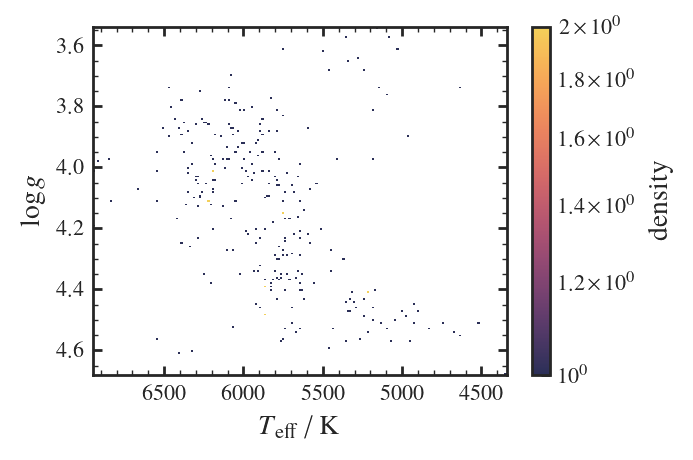

In [57]:
keil_plot(gso_uv["TEFF"], gso_uv["LOGG"])


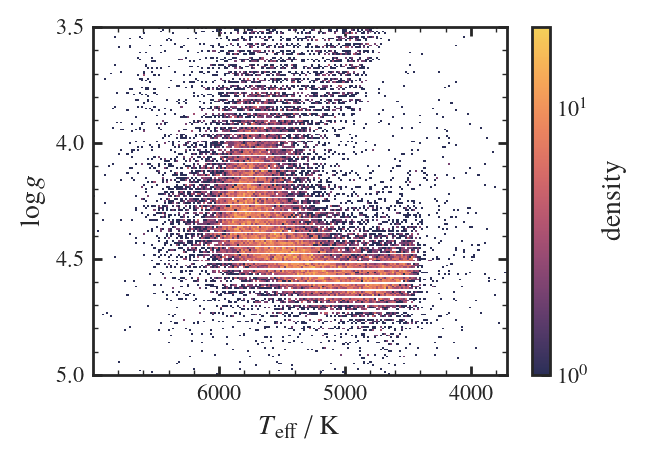

In [58]:
keil_plot(gso_lr["TEFF"], gso_lr["LOGG"])


Text(0, 0.5, '[C$_2$/Mg]')

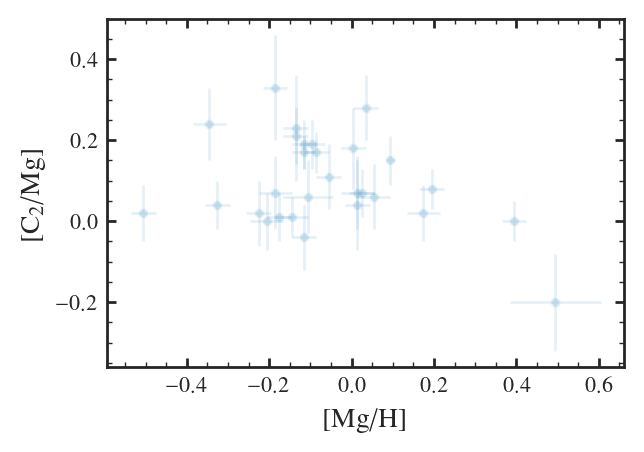

In [59]:
plt.errorbar(gso_uv.MG_H, gso_uv.C_MG, xerr=gso_uv.MG_H_ERR, yerr=gso_uv.C_MG_ERR, fmt="o", capsize=0, alpha=0.1)

plt.xlabel("[Mg/H]")
plt.ylabel(r"[C$_2$/Mg]")


Text(0, 0.5, '[C\\,I/Mg]')

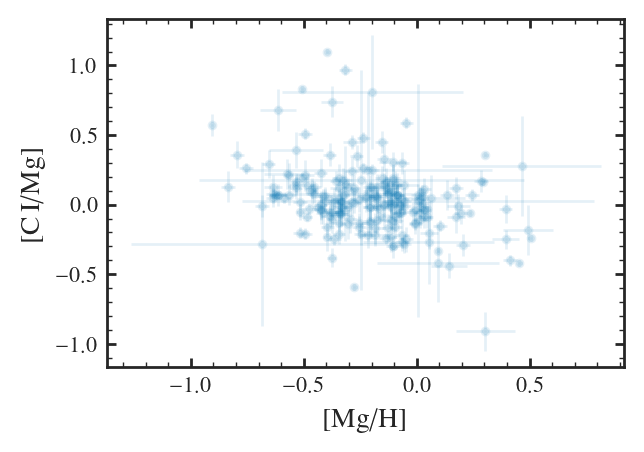

In [60]:
plt.errorbar(gso_uv.MG_H, gso_uv.CI_MG, xerr=gso_uv.MG_H_ERR, yerr=gso_uv.CI_MG_ERR, fmt="o", capsize=0, alpha=0.1)

plt.xlabel("[Mg/H]")
plt.ylabel(r"[C\,I/Mg]")


Text(0, 0.5, '[Mg/Fe]')

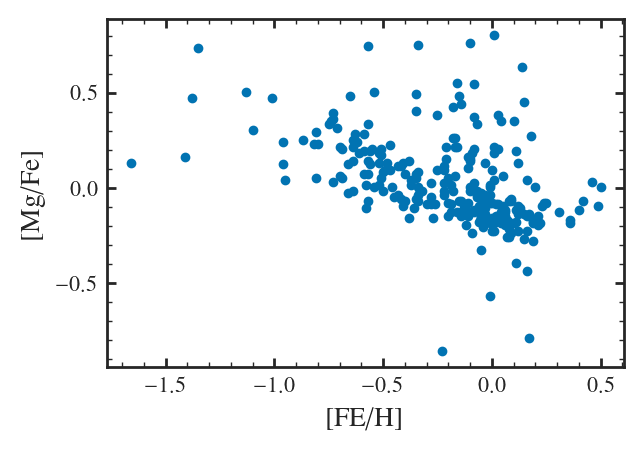

In [61]:
plt.scatter(gso_uv.FE_H, gso_uv.MG_FE);
plt.xlabel("[FE/H]")
plt.ylabel("[Mg/Fe]")

Looks okay, no bimodality

## low resolution survey

Text(0, 0.5, '[C\\,I/Mg]')

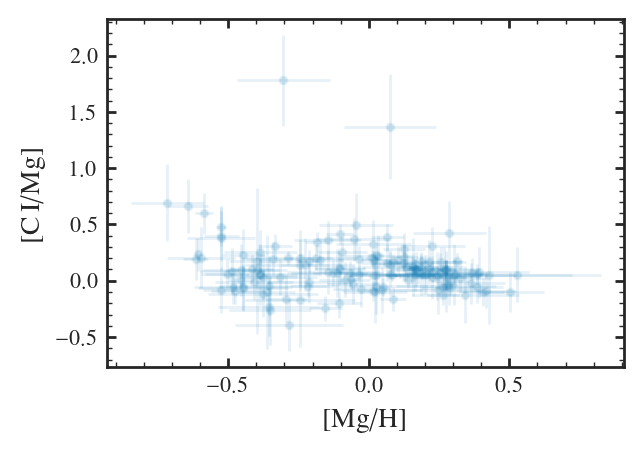

In [62]:
plt.errorbar(gso_lr.MG_H, gso_lr.CI_MG, xerr=gso_lr.MG_H_ERR, yerr=gso_lr.CI_MG_ERR, fmt="o", capsize=0, alpha=0.1)

plt.xlabel("[Mg/H]")
plt.ylabel(r"[C\,I/Mg]")


Text(0, 0.5, '[C\\,I/Mg]')

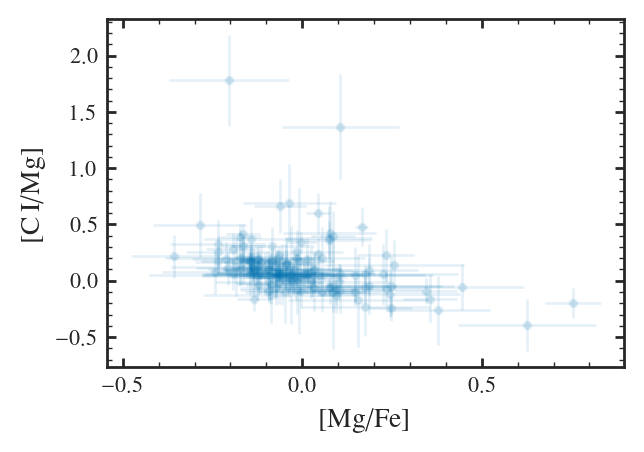

In [63]:
plt.errorbar(gso_lr.MG_FE, gso_lr.CI_MG, xerr=gso_lr.MG_H_ERR, yerr=gso_lr.CI_MG_ERR, fmt="o", capsize=0, alpha=0.1)

plt.xlabel("[Mg/Fe]")
plt.ylabel(r"[C\,I/Mg]")

Text(0, 0.5, '[Mg/Fe]')

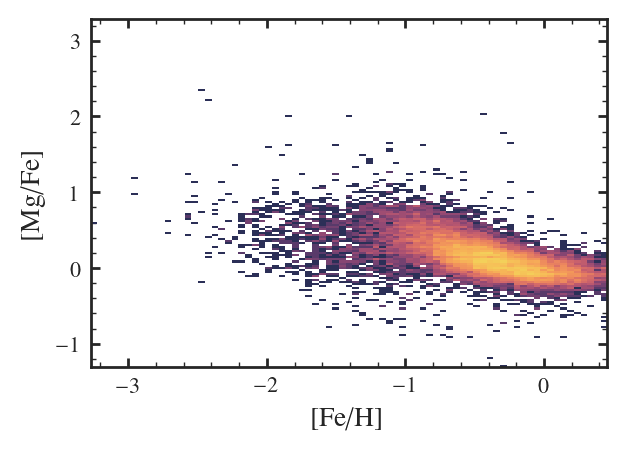

In [64]:
hist2d(gso_lr.FE_H, gso_lr.MG_FE)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")

Text(0, 0.5, '[C/Mg]')

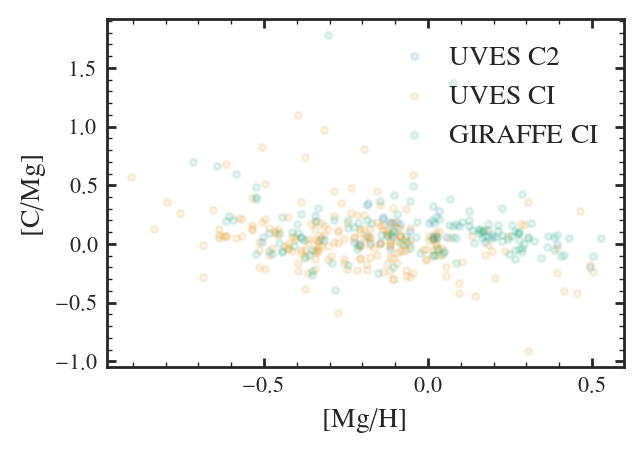

In [65]:
plt.scatter(gso_uv.MG_H, gso_uv.C_MG, alpha=0.1, label="UVES C2")
plt.scatter(gso_uv.MG_H, gso_uv.CI_MG, alpha=0.1, label="UVES CI")
plt.scatter(gso_lr.MG_H, gso_lr.CI_MG, alpha=0.1, label="GIRAFFE CI")
plt.legend()
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

In [66]:
filt = np.isnan(gso_dwarf["C_MG"]) & ~np.isnan(gso_dwarf["CI_MG"])

gso_dwarf.loc[filt, "C_MG"] = gso_dwarf["CI_MG"][filt]
gso_dwarf.loc[filt, "C_MG_ERR"] = gso_dwarf["CI_MG_ERR"][filt]

In [67]:
gso_dwarf["high_alpha"] = np.where(gso_dwarf.FE_H > 0, gso_dwarf.MG_FE > 0.00 - 0.1*gso_dwarf.FE_H, gso_dwarf.MG_FE > 0.00 - 0.35*gso_dwarf.FE_H)


/tmp/ipykernel_1933705/2231290568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gso_dwarf["high_alpha"] = np.where(gso_dwarf.FE_H > 0, gso_dwarf.MG_FE > 0.00 - 0.1*gso_dwarf.FE_H, gso_dwarf.MG_FE > 0.00 - 0.35*gso_dwarf.FE_H)


(-0.4, 0.8)

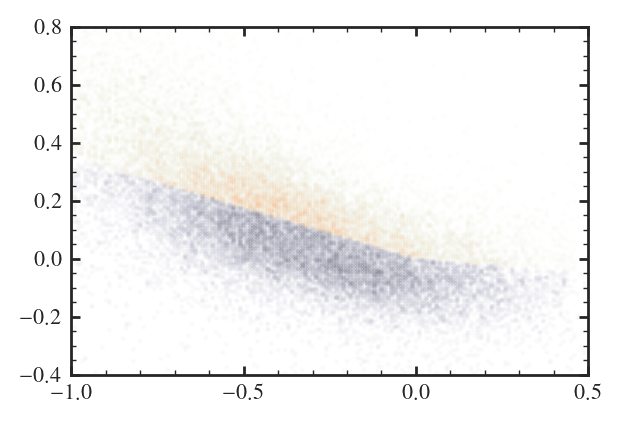

In [68]:
plt.scatter(gso_dwarf.FE_H, gso_dwarf.MG_FE, s=1, c=gso_dwarf.high_alpha, alpha=0.01)
plt.xlim(-1, 0.5)
plt.ylim(-0.4, 0.8)

In [69]:
gso_dwarf[gso_dwarf.C_MG_ERR > 0].to_csv("gso_dwarfs.csv")

In [70]:
print(np.sum(gso_lr.CI_MG_ERR > 0) / len(gso_lr))

0.00535667131917462


In [71]:
print(np.sum(gso_uv.CI_MG_ERR > 0 | (gso_uv.C_MG_ERR > 0)) / len(gso_uv))

0.7072243346007605


In [72]:
len(gso_uv)

263

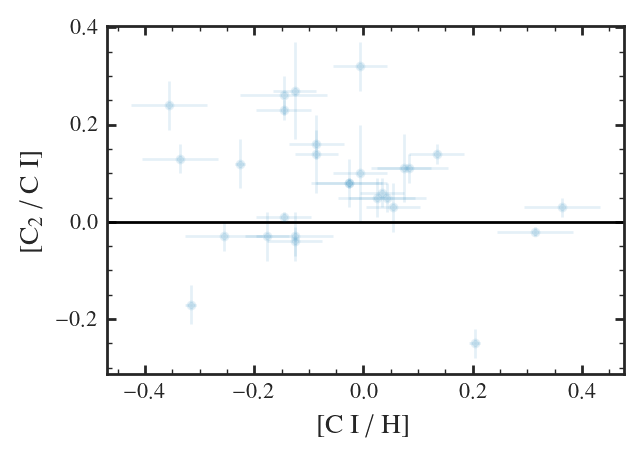

In [73]:
plt.errorbar(gso_uv.CI_H, gso_uv.CC_H - gso_uv.CI_H, xerr=gso_uv.CI_H_ERR, yerr=gso_uv.CC_H_ERR, fmt="o", capsize=0, alpha=0.1)
plt.xlabel("[C I / H]")
plt.ylabel(r"[C$_2$ / C I]")
plt.axhline(0, color="k")

In [74]:
len(gaiaeso_all[gaiaeso_all["REC_WG"] == b"WG11"])

6149

# DESI MWM

Description: MNRAS 533, 1012–1031 (2024) https://ui.adsabs.harvard.edu/abs/2024MNRAS.533.1012K/abstract. 

Data access:https://data.desi.lbl.gov/doc/access/
Data Model: https://desi-mws-edr-datamodel.readthedocs.io/en/latest/

see below, likely not reliable for this kind of work...


> The carbon and magnesium abundances reported by the SP
pipeline are unreliable. The reason carbon abundances are not
trustworthy is because of an issue with the coating of the DESI blue
collimators, which creates a throughput artefact in many spectra
around 4300 Å (see e.g. fig. 26 in DESI Collaboration 2022).
This is the region of the CH absorption band, which is the most
important indicator of carbon abundance in late-type stars at the
resolution of DESI. While the abundances of iron and calcium
show a good correlation with the \[Fe/H\] and \[α/Fe\] parameters
derived by the same pipeline, that is not the case for magnesium.
We, therefore, recommend not using the abundance of carbon or
magnesium included in the EDR MWS VAC.


From https://academic.oup.com/mnras/article/533/1/1012/7724389.
DESI EDR MWS VAC 1027
MNRAS 533, 1012–1031 (2024)


In [ ]:
f_desi = fits.open(f"{data_dir}/surveys/mwsall-pix-fuji.fits", memmap=True)

In [ ]:
f_desi[2].header

In [ ]:
desi = Table.read(f"{data_dir}/mwsall-pix-fuji.fits", format="fits", hdu=2, memmap=True)
desi_rv = Table.read(f"{data_dir}/mwsall-pix-fuji.fits", format="fits", hdu=1, memmap=True)

desi["TEFF_ERR"] = desi["COVAR"][:, 2, 2]**0.5

desi["FEH_ERR"] = desi["COVAR"][:, 0, 0]**0.5
desi["ALPHAFE_ERR"] = desi["COVAR"][:, 1, 1]**0.5
desi["LOGG_ERR"] = desi["COVAR"][:, 4, 4]**0.5
desi["TEFF_ERR"] = desi["COVAR"][:, 3, 3]**0.5




# this is not well documented, just guessing here
desi["C_H"] = desi["ELEM"][:, 0]
desi["MG_H"] = desi["ELEM"][:, 1]
desi["CA_H"] = desi["ELEM"][:, 2]
desi["FE_H"] = desi["ELEM"][:, 3]


desi["C_H_ERR"] = desi["ELEM_ERR"][:, 0]
desi["MG_H_ERR"] = desi["ELEM_ERR"][:, 1]
desi["CA_H_ERR"] = desi["ELEM_ERR"][:, 3]
desi["FE_H_ERR"] = desi["ELEM_ERR"][:, 2]

desi["C_MG"] = desi["C_H"] - desi["MG_H"]
desi["MG_FE"] = desi["MG_H"] - desi["FE_H"]


# filter out the worst of it

filt = desi["LOGG"] > 1
filt &= desi["LOGG"] < 5
filt &= desi["TEFF"] > 2000
filt &= desi["TEFF"] < 10_000
filt &= desi["FEH_ERR"] < 0.1
filt &= desi["TEFF_ERR"] < 100
filt &= desi["LOGG_ERR"] < 0.3

filt &= desi["SUCCESS"] > 0

print(len(desi))
print(sum(filt))
desi_rv = desi_rv[filt]
desi = desi[filt]

In [ ]:
keil_plot(desi["TEFF"], desi["LOGG"])

In [ ]:
keil_plot(desi_rv["TEFF"], desi_rv["LOGG"])

Keil diagram looks like nonsense, not a good sign...

## Abundance validation

In [ ]:
plt.hist2d(desi["FEH"], desi["FEH"] - desi_rv["FEH"], 100, range=((-3, 1), (-0.5, 0.5)), );

In [ ]:
plt.hist2d(desi["ALPHAFE"], desi["ALPHAFE"] - desi_rv["ALPHAFE"], 100, range=((-1, 1), (-1, 1)), );

In [ ]:
plt.hist(desi["ELEM_ERR"][:, 3], 100, range=(0, 0.5));

Fe errors (above) do not correspond with abundance versus stellar parameter errors.

In [ ]:
plt.hist2d(desi["FEH"], desi["FEH"] - desi["FE_H"], 100, range=((-1, 1), (-1, 1)), );

In [ ]:
plt.hist2d(desi["MG_FE"], desi["ALPHAFE"] - desi["MG_FE"], 100, range=((-1, 1), (-1, 1)), );

## Plots

In [ ]:
plt.hist2d(desi["FE_H"], desi["MG_FE"], 100, range=((-1, 1), (-1, 1)), );

almost looks believable

In [ ]:
plt.hist2d(desi["MG_H"], desi["C_MG"], 100, range=((-1, 1), (-1, 1)), );

this one not so much

# LAMOST (Cycle-StarNet)


https://ui.adsabs.harvard.edu/abs/2023ApJS..266...40W/abstract
On website uses the other version...

In [ ]:
table = pd.read_csv(data_dir + "surveys/lamost_dr8.csv")

In [ ]:
table.columns

In [ ]:
qual_filt = table["Flag_quality"] == 0
qual_filt &= table["Flag_logg"] == 0
qual_filt &= table["Flag_Teff"] == 0

In [ ]:
keil_plot(table["Teff"][qual_filt], table["logg"][qual_filt])

In [ ]:
filt = qual_filt.copy()
filt &= table["logg"] > 3.5
filt &= table["logg"] < 5
filt &= table["Teff"] < 7000
filt &= table["Teff"] > 4000
filt &= table["Flag_FeH"] == 0
filt &= table["Flag_MgFe"] == 0

In [ ]:
lamost = table[qual_filt].copy()

In [ ]:
def rename_lamost_columns(col):
    new_name = col.rstrip('_').upper()
    if new_name.endswith("FE"):
        new_name = new_name[:-2] + "_FE"
    if new_name == "FEH":
        new_name = "FE_H"
        
    if new_name.startswith('ERR_'):
        new_name = new_name[4:] + '_ERR'
        
    if new_name.startswith('FLAG_'):
        new_name = new_name[5:] + '_FLAG'    
    new_name = new_name.lstrip("_")

    return new_name

In [ ]:
lamost.columns = [rename_lamost_columns(col) for col in lamost.columns]

In [ ]:
lamost.columns

In [ ]:
lamost["MG_H"] = lamost.FE_H + lamost.MG_FE

lamost["C_MG"] = lamost.C_FE - lamost.MG_FE

In [ ]:
lamost_c = lamost[lamost.C_FE_FLAG == 0]

In [ ]:
plot_ab(lamost, "FE_H", "MG_FE")

In [ ]:
plot_ab(lamost_c, "MG_H", "C_MG")

In [ ]:
len(lamost_c) / len(lamost)

In [ ]:
plot_ab(lamost_c, "MG_FE", "C_MG")

In [ ]:
lamost_c.to_csv("lamost_dwarfs.csv")

# Crossmathing

In [ ]:
def crossmatch_test(df1, df2, col, s=1, alpha=0.1, **kwargs):
    x1 = np.array(df1[col])
    x2 = np.array(df2[col])
    plt.scatter(x1, x2-x1, s=s, alpha=alpha, **kwargs)
    plt.axhline(0, c="k")
    plt.xlabel(col.replace("_", "/"))
    plt.ylabel("delta " + col.replace("_", "/"))

In [ ]:
def crossmatch_test_hist(df1, df2, col, range=None, **kwargs):
    x1 = np.array(df1[col])
    x2 = np.array(df2[col])

    hist2d(x1, x2-x1, **kwargs)
    plt.axhline(0, c="k")
    plt.xlabel(col.replace("_", "/"))
    plt.ylabel("delta " + col.replace("_", "/"))
    plt.colorbar(label="count")

In [ ]:
from surp import subgiants
from astropy.coordinates import SkyCoord
from astropy import units as u


In [ ]:
def get_crossmatch(ra1, dec1, ra2, dec2, max_sep=1*u.arcsec):
    ra1 = np.array(ra1)
    dec1 = np.array(dec1)
    ra2 = np.array(ra2)
    dec2 = np.array(dec2)
    
    # Convert catalogue positions into SkyCoord objects
    coords1 = SkyCoord(ra=ra1 * u.degree, dec=dec1 * u.degree)
    coords2 = SkyCoord(ra=ra2 * u.degree, dec=dec2 * u.degree)

    # Perform crossmatch
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

    sep_constraint = d2d < max_sep

    # Filter matches
    matches = idx[sep_constraint]
    matched_d2d = d2d[sep_constraint]


    idx_l = np.where(sep_constraint)[0] #df indicies
    idx_r = matches # apogee indicies

    print(len(ra1))
    print(len(ra2))
    print(len(idx_l))
    
    plt.scatter(ra2, dec2,  s=0.01, alpha=1, label="2")

    plt.scatter(ra1, dec1,  s=0.01, alpha=1, label="1")
    plt.xlabel("RA")
    plt.ylabel("DEC")
    plt.show()
    
    plt.scatter(ra2[idx_r], dec2[idx_r], 
                s=0.01, alpha=1, label="match")
    plt.scatter(ra1[idx_l], dec1[idx_l],
                s=0.01, alpha=1, label="match")
    plt.xlabel("RA")
    plt.ylabel("DEC")
    
    return idx_l, idx_r

In [ ]:
# comes from the notebook APOGEE_minimal.ipynb
apogee = pd.read_csv(f"{data_dir}/apogee_most.csv")

In [ ]:
# remove test star
apogee = apogee[1:]
apogee.reset_index()

## GALAH - APOGEE

In [ ]:
idx_l, idx_r = get_crossmatch(galah.ra, galah.dec, apogee.RA, apogee.DEC)

In [ ]:
for col in ["LOGG", "TEFF", "FE_H", "MG_FE", "C_MG"]:
    crossmatch_test_hist(galah.iloc[idx_l], apogee.iloc[idx_r], col, alpha=1)
    plt.show()

## Crossmatch GaiaESO

In [ ]:
idx_l, idx_r = get_crossmatch(gaiaeso.RA, gaiaeso.DECLINATION, apogee.RA, apogee.DEC, max_sep=10*u.arcsec)


In [ ]:
for col in ["LOGG", "TEFF", "FE_H", "MG_FE", "C_MG"]:
    crossmatch_test(gaiaeso.iloc[idx_l], apogee.iloc[idx_r], col, alpha=1)
    plt.show()

## galah - gaiaeso

In [ ]:
idx_l, idx_r = get_crossmatch(gaiaeso.RA, gaiaeso.DECLINATION, galah.ra, galah.dec, max_sep=1*u.arcsec)


In [ ]:
for col in ["LOGG", "TEFF", "FE_H", "MG_FE", "C_MG"]:
    crossmatch_test(gaiaeso.iloc[idx_l], galah.iloc[idx_r], col, alpha=0.5)
    plt.show()

## LAMOST - APOGEE


In [ ]:
filt = apogee.STARFLAG == 0
filt &= apogee.ASPCAPFLAG == 0

In [ ]:
idx_l, idx_r = get_crossmatch(lamost.RA, lamost.DEC, apogee[filt].RA, apogee[filt].DEC, max_sep=1*u.arcsec)


In [ ]:
for col in ["LOGG", "TEFF", "FE_H", "MG_FE", "C_FE"]:
    crossmatch_test_hist(lamost.iloc[idx_l], apogee[filt].iloc[idx_r], col)
    plt.show()

## Lamost - GALAH

In [ ]:
idx_l, idx_r = get_crossmatch(lamost.RA, lamost.DEC, galah.ra, galah.dec, max_sep=1*u.arcsec)


In [ ]:
for col in ["LOGG", "TEFF", "FE_H", "MG_FE", "C_MG"]:
    crossmatch_test_hist(lamost.iloc[idx_l], galah.iloc[idx_r], col)
    plt.show()